<a href="https://colab.research.google.com/github/seismomat/IBEM/blob/Luis/Caso_SH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INDIRECT BOUNDARY ELEMENT METHOD (IBEM)

In [189]:
import math
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import scipy.special as scis
from scipy.special import hankel1, hankel2
from scipy import integrate
from scipy.integrate import fixed_quad

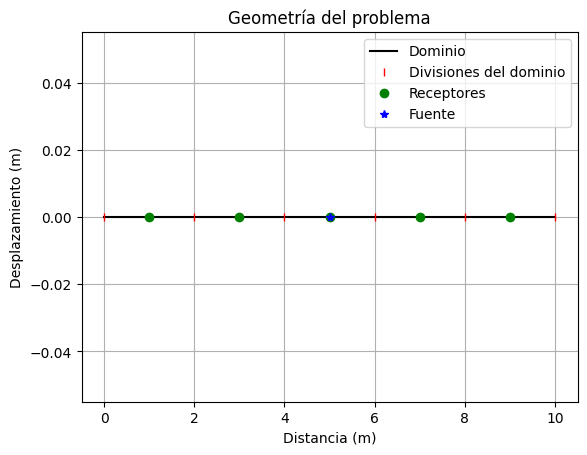

In [190]:
#Hay que revisar todo, hay cosas mal T-T
#Visualización del problema
L=10  #Longitud del dominio
Np=6  #Número de puntos en el dominio
F=5   #Posición de la fuente

#Propiedades del medio
Rho=3200
lam=1000
mu=10000
k=1
alfa=np.sqrt((lam+(2*mu))/Rho)
beta=np.sqrt(mu/Rho)

x=np.linspace(0,L,Np) #Puntos de la "malla"
y=np.zeros(len(x))
#Puntos medios
x_m=[]
for i in range(len(x)-1):
  x_m.append(((x[i+1]-x[i])/2)+x[i])
y_m=np.zeros(len(x_m))

#Visualización de la geometría
plt.plot(x,y,'k',label='Dominio')
plt.plot(x,y,'|r',label='Divisiones del dominio')
plt.plot(x_m,y_m,'og',label='Receptores')
plt.plot(F,0,'*b',label='Fuente')
plt.xlabel('Distancia (m)')
plt.ylabel('Desplazamiento (m)')
plt.title('Geometría del problema')
plt.grid()
plt.legend()
plt.show()

RESOLUCIÓN DEL SISTEMA DE ECUACIONES

In [191]:
#DEFINICIÓN DE FUNCIONES A EMPLEAR
#Se emplea para el cálculo de T22 (función de Hankel de segunda especie de orden uno)
def d(k,r):
  D=k*r*hankel2(1,k*r)
  return D

#Se emplea para el cálculo de G22 (función de Hankel de segunda especie de orden cero)
def h(k,r):
  H=hankel2(0,k*r)
  return H

#Delta de Kronecker
def Kron(n,l):
  if n==l:
    return 1
  else:
    return 0

In [192]:
#Cálculo de T_22
Xi=x_m
X=x_m
i=1j
Vector_un=1

r=np.zeros((len(Xi),len(X)))
Gamma=np.zeros((len(Xi),len(X)))
T_22=np.zeros((len(Xi),len(Xi)),dtype=complex)
for n in range(len(Xi)):
  for l in range(len(Xi)):
    #Cálculo de r
    r[n][l]=(np.linalg.norm(X[n]-Xi[l]))
    #Cálculo de Gamma
    if n==l:
      Gamma[n][l]=0
    else:
      Gamma[n][l]=((X[n]-Xi[l])/(np.linalg.norm(X[n]-Xi[l])))
      #T_22=(i*Gamma*Vector_un*d(k,r))/(4*(np.linalg.norm(X[n]-Xi[l])))
    Hankel=d(k,r)
    #Es una matriz
    S=(Hankel*Gamma)

    if n!=l:
      T_22[n][l]=((Hankel[n][l])*(Gamma[n][l])*i)/(4*r[n][l])
    else:
      T_22[n][l]=0
#Hasta este punto la definición de los parámetros es correcta (Se supone xD)
print(T_22)



[[ 0.        +0.j          0.02675811-0.1441812j  -0.09948143+0.01651083j
   0.04375259+0.06917096j  0.03951512-0.05865909j]
 [-0.02675811+0.1441812j   0.        +0.j          0.02675811-0.1441812j
  -0.09948143+0.01651083j  0.04375259+0.06917096j]
 [ 0.09948143-0.01651083j -0.02675811+0.1441812j   0.        +0.j
   0.02675811-0.1441812j  -0.09948143+0.01651083j]
 [-0.04375259-0.06917096j  0.09948143-0.01651083j -0.02675811+0.1441812j
   0.        +0.j          0.02675811-0.1441812j ]
 [-0.03951512+0.05865909j -0.04375259-0.06917096j  0.09948143-0.01651083j
  -0.02675811+0.1441812j   0.        +0.j        ]]


In [193]:
#Integración Gaussiana

T_22_int=np.zeros((len(Xi),len(Xi)),dtype=complex)
for n in range(len(Xi)-1):
  for l in range(len(Xi)-1):
    a=Xi[n]
    b=Xi[n+1]
    def integrando(x):
      return T_22[n][l]
    T_22_int[n][l], _ =integrate.quad(integrando,a,b)


print(T_22_int)

[[ 0.        +0.j  0.05351622+0.j -0.19896286+0.j  0.08750517+0.j
   0.        +0.j]
 [-0.05351622+0.j  0.        +0.j  0.05351622+0.j -0.19896286+0.j
   0.        +0.j]
 [ 0.19896286+0.j -0.05351622+0.j  0.        +0.j  0.05351622+0.j
   0.        +0.j]
 [-0.08750517+0.j  0.19896286+0.j -0.05351622+0.j  0.        +0.j
   0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j]]


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


In [194]:
#Matriz de tracciones (t22)
n=len(x_m)
l=len(x_m)
t_22=np.zeros((n,l),dtype=complex)
for n in range(len(x_m)):
  for l in range(len(x_m)):
    if n==l:
      t_22[n][l]=(0.5)*Kron(n,l)+T_22_int[n][l]
    else:
      t_22[n][l]=Kron(n,l)+T_22_int[n][l]
print(np.real(t_22))


[[ 0.5         0.05351622 -0.19896286  0.08750517  0.        ]
 [-0.05351622  0.5         0.05351622 -0.19896286  0.        ]
 [ 0.19896286 -0.05351622  0.5         0.05351622  0.        ]
 [-0.08750517  0.19896286 -0.05351622  0.5         0.        ]
 [ 0.          0.          0.          0.          0.5       ]]


In [198]:
#RESOLUCIÓN DEL SISTEMA DE ECUACIONES
t_0=-(np.ones(len(Xi)))
t_22_inv=np.linalg.inv((t_22))
phi=t_22_inv@t_0
print(phi)
#revisar vector de tracciones en la superficie (t_0)

[-1.99604399+0.j -2.64385718+0.j -1.33456265+0.j -1.44011108+0.j
 -2.        +0.j]


In [199]:
#Cálculo del campo difractado
#Cálculo de G_22
G_22=np.zeros((len(Xi),len(Xi)),dtype=complex)
for n in range(len(Xi)):
  for l in range(len(Xi)):
    Hankel0=h(k,r)
    if n!=l:
      G_22[n][l]=(Hankel0[n][l])/(4*Rho*i*beta**2)
    else:
      G_22[n][l]=0

#Cálculo de g_22 (Integración Gaussiana)
g_22=np.zeros((len(Xi),len(Xi)),dtype=complex)
for n in range(len(Xi)-1):
  for l in range(len(Xi)-1):
    a=Xi[n]
    b=Xi[n+1]
    def integrando(x):
      return G_22[n][l]
    g_22[n][l], _ =integrate.quad(integrando,a,b)

#Campo difractado
u_d=g_22@phi

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


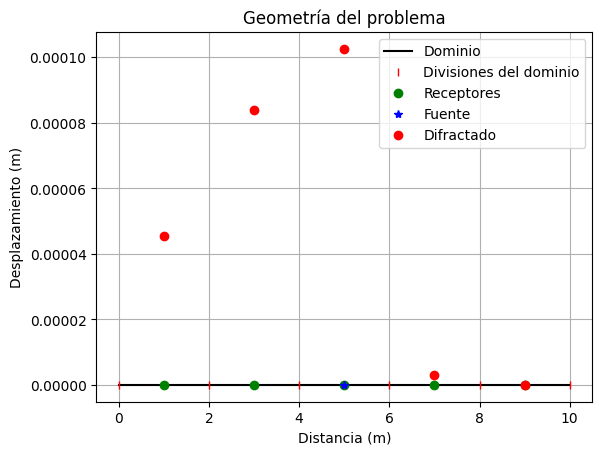

In [200]:
#Visualización de la geometría
plt.plot(x,y,'k',label='Dominio')
plt.plot(x,y,'|r',label='Divisiones del dominio')
plt.plot(x_m,y_m,'og',label='Receptores')
plt.plot(F,0,'*b',label='Fuente')
plt.plot(x_m,np.real(u_d),'or',label='Difractado')
plt.xlabel('Distancia (m)')
plt.ylabel('Desplazamiento (m)')
plt.title('Geometría del problema')
plt.grid()
plt.legend()
plt.show()